In [1]:
%pylab inline
import sys
sys.dont_write_bytecode = True

Populating the interactive namespace from numpy and matplotlib


In [2]:
config = {}
config['batch_size'] = 32
config['workers'] = 4
from data_io import get_dataloader
train_lst, valid_lst, train_dataset, valid_dataset, train_loader, valid_loader = get_dataloader(config)

Got 20000 items in train mode.
Got 5000 items in valid mode.


In [3]:
for imgs, labs in valid_loader:
    break

In [4]:
imgs = imgs.numpy()
imgs = imgs.transpose([0, 2, 3, 1])

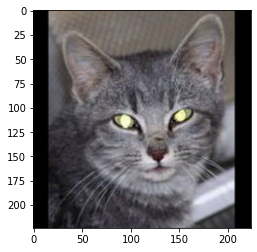

In [5]:
idx = 0
imshow(imgs[idx])

In [6]:
aa = imgs[0, 1::4, 1::4, :]

In [7]:
aa.shape

(56, 56, 3)

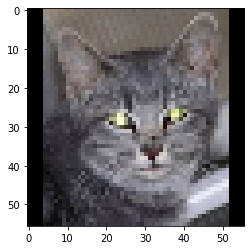

In [8]:
imshow(aa)

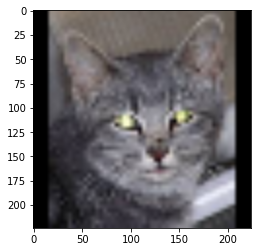

In [9]:
import cv2
imshow(cv2.resize(aa, (224, 224)))